In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#%pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Dense,
    Flatten,
    Concatenate,
    Multiply,
    Attention,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2024-06-20 10:53:36.490297: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Users
u_cols = ['user_id', 'location', 'age']
users = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX-Users.csv', sep=';', names=u_cols, encoding='latin-1',low_memory=False)

#Books
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
items = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX_Books.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False)

#Ratings
r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX-Book-Ratings.csv', sep=';', names=r_cols, encoding='latin-1',low_memory=False)

In [3]:
users.head(10)

,user_id,location,age
0,User-ID,Location,Age
1,1,"nyc, new york, usa",NaN
2,2,"stockton, california, usa",18
3,3,"moscow, yukon territory, russia",NaN
4,4,"porto, v.n.gaia, portugal",17
5,5,"farnborough, hants, united kingdom",NaN
6,6,"santa monica, california, usa",61
7,7,"washington, dc, usa",NaN
8,8,"timmins, ontario, canada",NaN
9,9,"germantown, tennessee, usa",NaN


In [4]:
items.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
0,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
3,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
4,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...


In [5]:
ratings.head()

,user_id,isbn,rating
0,User-ID,ISBN,Book-Rating
1,276725,034545104X,0
2,276726,0155061224,5
3,276727,0446520802,0
4,276729,052165615X,3


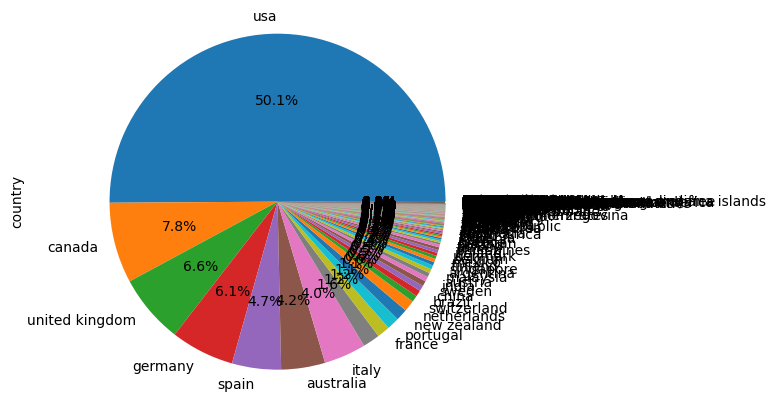

In [6]:
import matplotlib.pyplot as plt

# Extract the country information from the location column
users['country'] = users['location'].str.split(',').str[-1].str.strip()

# Count the occurrences of each country
country_counts = users['country'].value_counts()

# Plot the pie chart
country_counts.plot.pie(autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [7]:
users.age.describe()

count     168097
unique       166
top           24
freq        5687
Name: age, dtype: object

In [8]:
users.age.unique() 

array(['Age', nan, '18', '17', '61', '26', '14', '25', '19', '46', '55',
       '32', '24', '20', '34', '23', '51', '31', '21', '44', '30', '57',
       '43', '37', '41', '54', '42', '50', '39', '53', '47', '36', '28',
       '35', '13', '58', '49', '38', '45', '62', '63', '27', '33', '29',
       '66', '40', '15', '60', '0', '79', '22', '16', '65', '59', '48',
       '72', '56', '67', '1', '80', '52', '69', '71', '73', '78', '9',
       '64', '103', '104', '12', '74', '75', '231', '3', '76', '83', '68',
       '119', '11', '77', '2', '70', '93', '8', '7', '4', '81', '114',
       '230', '239', '10', '5', '148', '151', '6', '101', '201', '96',
       '84', '82', '90', '123', '244', '133', '91', '128', '94', '85',
       '141', '110', '97', '219', '86', '124', '92', '175', '172', '209',
       '212', '237', '87', '162', '100', '156', '136', '95', '89', '106',
       '99', '108', '210', '88', '199', '147', '168', '132', '159', '186',
       '152', '102', '116', '200', '115', '226', '137'

In [9]:
# Dropping the header row
users.drop(users.index[0], inplace=True)
items.drop(items.index[0], inplace=True)
ratings.drop(ratings.index[0], inplace=True)

In [10]:
# Merge the three forms of data
df = pd.merge(users, ratings, on="user_id")

df = pd.merge(items, df, on="isbn")
# df.head()

In [11]:
# Check for missing values
df.isnull().sum()

isbn                        0
book_title                  0
book_author                 1
year_of_publication         0
publisher                   2
img_s                       0
img_m                       0
img_l                       0
user_id                     0
location                    0
age                    277845
country                     0
rating                      0
dtype: int64

In [12]:
# Drop the missing values
df.dropna(inplace=True)
df.isnull().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
img_s                  0
img_m                  0
img_l                  0
user_id                0
location               0
age                    0
country                0
rating                 0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753327 entries, 0 to 1031174
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 753327 non-null  object
 1   book_title           753327 non-null  object
 2   book_author          753327 non-null  object
 3   year_of_publication  753327 non-null  object
 4   publisher            753327 non-null  object
 5   img_s                753327 non-null  object
 6   img_m                753327 non-null  object
 7   img_l                753327 non-null  object
 8   user_id              753327 non-null  object
 9   location             753327 non-null  object
 10  age                  753327 non-null  object
 11  country              753327 non-null  object
 12  rating               753327 non-null  object
dtypes: object(13)
memory usage: 80.5+ MB


In [14]:
# Convert the data types
df["user_id"] = df["user_id"].astype(int)
df["isbn"] = df["isbn"].astype(str)
df["rating"] = df["rating"].astype(float)
df["year_of_publication"] = df["year_of_publication"].astype(int)

In [15]:
# Re-index user_id and isbn
user_id_mapping = {id: idx for idx, id in enumerate(df["user_id"].unique())}
isbn_mapping = {isbn: idx for idx, isbn in enumerate(df["isbn"].unique())}

df["user_id"] = df["user_id"].map(user_id_mapping)
df["isbn"] = df["isbn"].map(isbn_mapping)

Text(0.5, 1.0, 'Authors with Most Ratings')

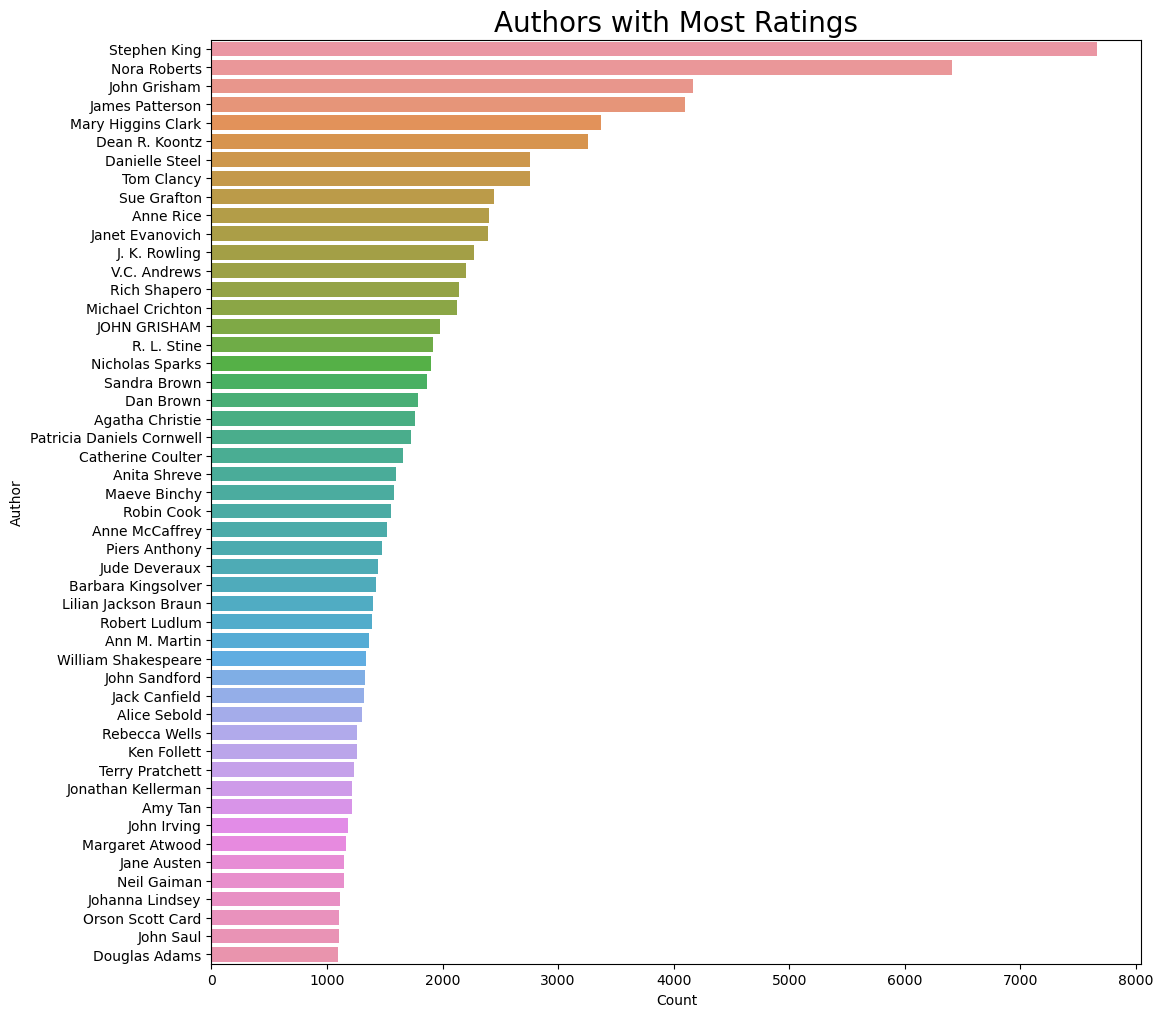

In [16]:
# Authors with most ratings
plt.figure(figsize=(12, 12))
sns.barplot(x=df['book_author'].value_counts().head(50), y=df['book_author'].value_counts().head(50).index)
plt.xlabel("Count")
plt.ylabel("Author")
plt.title("Authors with Most Ratings", size=20)

In [17]:
ds1 = df["book_author"].value_counts().head(50).reset_index()
ds1.columns = ["author", "count"]
ds1.head()

,author,count
0,Stephen King,7664
1,Nora Roberts,6407
2,John Grisham,4168
3,James Patterson,4096
4,Mary Higgins Clark,3372


In [18]:
# Books with most ratings
ds = df["book_title"].value_counts().head(50).reset_index()
ds.columns = ["book", "count"]
ds.head()

,book,count
0,Wild Animus,2141
1,The Lovely Bones: A Novel,920
2,The Da Vinci Code,708
3,Bridget Jones's Diary,599
4,The Nanny Diaries: A Novel,573


Text(0.5, 1.0, 'Books with Most Ratings')

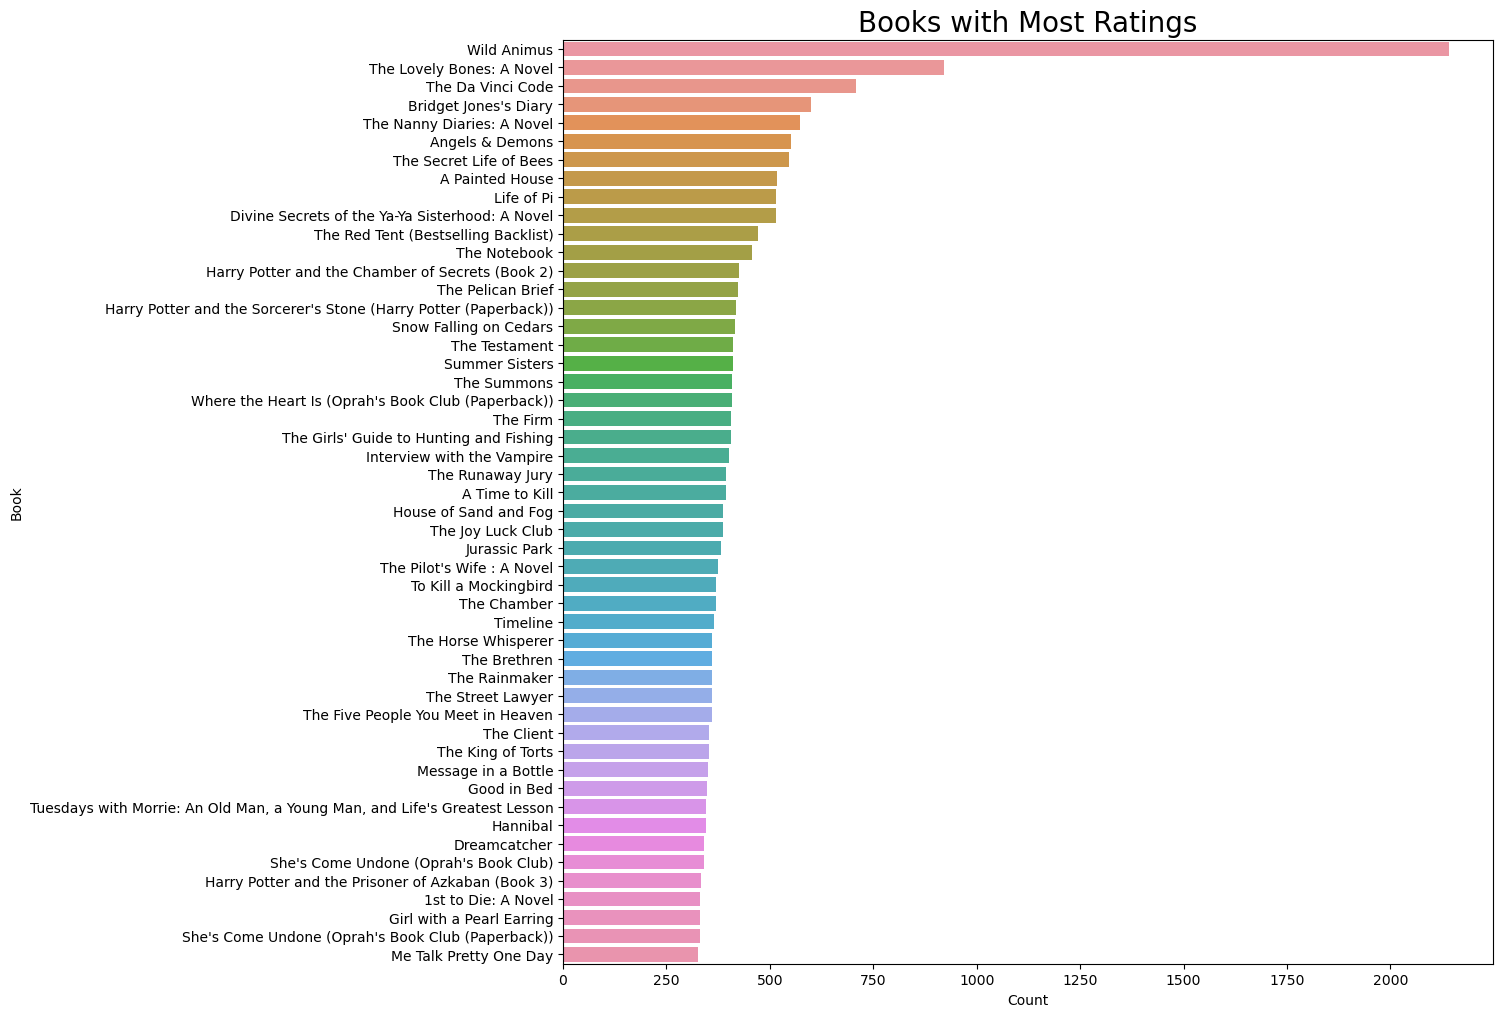

In [19]:
# Books with most ratings
plt.figure(figsize=(12, 12))
sns.barplot(x=ds['count'], y=ds['book'])
plt.xlabel("Count")
plt.ylabel("Book")
plt.title("Books with Most Ratings", size=20)

In [20]:
# Split the dataset into training, validation, and test sets
# Splits the original dataset df into two parts: 80% of the data is assigned to train, and 20% is assigned to test.
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Splits the train dataset into two parts: 80% of the data is assigned to train, and 20% is assigned to val.
train, val = train_test_split(train, test_size=0.2, random_state=42)
# In the end, we have train: 64% of the original dataset, val: 16% of the original dataset, test: 20% of the original dataset.

In [21]:
# Extracting the input arrays
user_ids_train = train["user_id"].values
item_ids_train = train["isbn"].values
ratings_train = train["rating"].values.astype(float)
user_ids_val = val["user_id"].values
item_ids_val = val["isbn"].values
ratings_val = val["rating"].values.astype(float)

In [22]:
# Matrix Factorization with Neural Networks (MF-NN)
# This leverages collaborative filtering with deep learning for user-item interaction modeling.


# Define MF-NN Model
def mf_nn_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim)(
        user_input
    )
    item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim)(
        item_input
    )

    user_vector = Flatten()(user_embedding)
    item_vector = Flatten()(item_embedding)

    concat = Concatenate()([user_vector, item_vector])

    dense = Dense(128, activation="relu")(concat)
    dense = Dense(64, activation="relu")(dense)
    output = Dense(1)(dense)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(), loss="mse")

    return model

In [23]:
num_users = len(user_id_mapping)
num_items = len(isbn_mapping)
# This is the dimension of the embedding vectors for both users and items.
# It determines the size of the latent factors space where users and items are projected. A higher dimension can capture more complex interactions but also increases the computational complexity and risk of overfitting.
embedding_dim = 50

In [29]:
# Train the MF-NN model
model_mf_nn = mf_nn_model(num_users, num_items, embedding_dim)
model_mf_nn.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 50)     │  2,694,400 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 50)     │ 11,450,650 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     12,928 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,166,299 (54.04 MB)

 Trainable params: 14,166,299 (54.04 MB)

 Non-trainable params: 0 (0.00 B)